In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=False)
df=data['df']
df.head()

,X0,X1,Z0,Z1,W0,W1,W2,W3,v,y
0,-0.997433,1.144633,1.0,0.966457,-0.752958,1.486046,0.864371,0.009197,19.600829,155.409394
1,0.776977,-1.884411,1.0,0.220696,-1.481974,1.454758,0.869564,0.786121,14.049269,153.058636
2,-0.124022,-2.151046,1.0,0.449039,0.322392,2.099575,-1.387424,0.521850,10.968154,68.199228
3,-1.333428,0.585457,1.0,0.363278,0.288631,1.520276,-1.394706,1.485303,10.716332,58.457580
4,-0.033447,-0.781361,1.0,0.390149,0.731389,2.095300,-0.607648,-0.905351,11.061411,98.583025


In [4]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v'] on outcome ['y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


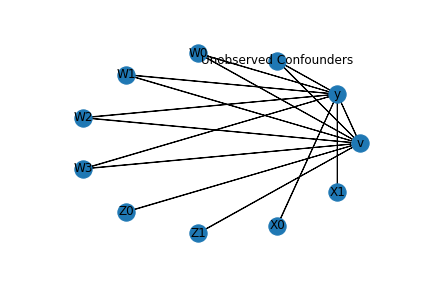

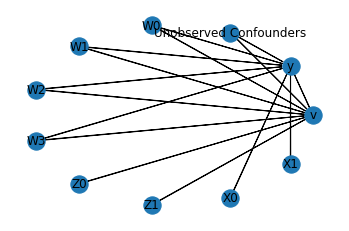

In [5]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [6]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W0', 'W2', 'Unobserved Confounders', 'W1', 'W3']


WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W1,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W1,W3,U) = P(y|v,W0,W2,W1,W3)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)



In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W1+W3


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W1,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W1,W3,U) = P(y|v,W0,W2,W1,W3)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v+W0+W2+W1+W3
## Estimate
Value: 7.989034840098185



In [8]:
print("True causal estimate is", data["ate"])

True causal estimate is 7.180911446322735


### CATE Object and Confidence Intervals

In [12]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=True,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals[:10])

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W1+W3
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W1,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W1,W3,U) = P(y|v,W0,W2,W1,W3)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v+W0+W2+W1+W3
## Estimate
Value: 7.912063829544788

[[7.91761749]
 [7.89348148]
 [7.9093068 ]
 [7.96893362]
 [7.88449588]
 [7.91521775]
 [7.92087393]
 [7.92587435]
 [7.93470652]
 [7.91293058]
 [7.93170984]
 [7.88764826]
 [7.89037747]
 [7.92005234]
 [7.94280467]
 [7.92728267]
 [7.95084496]
 [7.90527491]
 [7.90878665]
 [7.91683555]
 [7.93383095]
 [7.91984715]
 [7.91195143]
 [7.93362811]
 [7.91905701]
 [7.9448

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


# Works with any EconML method

In [ ]:
## Continuous treatment, Continuous outcome

In [15]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, 
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W1+W3
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   27.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   24.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  6.4min


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                             
──(Expectation(y|W0,W2,W1,W3))
dv                            
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,W0,W2,W1,W3,U) = P(y|v,W0,W2,W1,W3)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)

## Realized estimand
b: y~v+W0+W2+W1+W3
## Estimate
Value: 7.8893804130771885



[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  8.4min finished


In [17]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.drlearner.LinearDRLearner",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W1+W3


ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

## Instrumental Variable Method

In [28]:
 import keras
from econml.deepiv import DeepIVEstimator
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(2,)),
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v+W0+W2+W1+W3


Epoch 1/25
10000/10000 [==============================] - 3s 285us/step - loss: 4.7442
Epoch 2/25
10000/10000 [==============================] - 3s 277us/step - loss: 2.6373
Epoch 3/25
10000/10000 [==============================] - 3s 274us/step - loss: 2.5139
Epoch 4/25
10000/10000 [==============================] - 3s 274us/step - loss: 2.4702
Epoch 5/25
10000/10000 [==============================] - 3s 273us/step - loss: 2.4447
Epoch 6/25
10000/10000 [==============================] - 2s 228us/step - loss: 2.4245
Epoch 7/25
10000/10000 [==============================] - 3s 256us/step - loss: 2.4097
Epoch 8/25
10000/10000 [==============================] - 3s 262us/step - loss: 2.4042
Epoch 9/25
10000/10000 [==============================] - 3s 266us/step - loss: 2.4022
Epoch 10/25
10000/10000 [==============================] - 2s 241us/step - loss: 2.3923
Epoch 11/25
10000/10000 [==============================] - 3s 260us/step - loss: 2.3908
Epoch 12/25
10000/10000 [================

### Linear Model 

In [ ]:
linear_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(linear_estimate)

## Refuting the estimate

### Random 

In [ ]:
res_random=model.refute_estimate(identified_estimand, econml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, econml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

#### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

#### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, econml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)